# FCNs for semantic segmentation

In this exercise we will look at the basics how to build a fully convolutional network for semantic segmentation.

## A first example

In [1]:
# install all needed packages
from typing import Tuple
import numpy as np
import skimage
import skimage.data
import skimage.io
import tensorflow.keras as keras


# for displaying images in jupyter
from matplotlib import pyplot as plt

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
#mpl.rcParams['figure.dpi']= 400

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: cannot open shared object file: No such file or directory']
  warnings.warn(f"file s

In [2]:
# check tensorflow installation to see if we have GPU support
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5987953005949363502
xla_global_id: -1
]


### Images for smoke tests

When building a new network, it is a good idea to check if the network works at all, as it can sometimes take a while until all the parameters are fixed. For that we generate some function to create some simple test images that we can use.

In [3]:
def gen_random_binary_test_image(height: int, width: int)->(np.ndarray, np.ndarray):
    """
    Generate a test image and an appropriate label image with label 0 or label 1
    Label 0 images have a lower medium grayscale value, label 1 images a higher one.
    
    The returned images will have shape (height, width, 1) and type uint8 to be as compatible as possible to 
    mages read from files
    """
    VALUE = [100.0, 200.0]
    CLASS_ID = [0, 1]
    NOISE = 20.0
    
    label = np.zeros((height, width, 1), dtype=np.uint8)
    class_id = np.random.choice(CLASS_ID)
    label.fill(class_id)
    img = np.random.normal(VALUE[class_id], NOISE, ((height, width, 1))).astype(np.uint8)
    
    return img, label

mean: 198.96002197265625
mask: 1


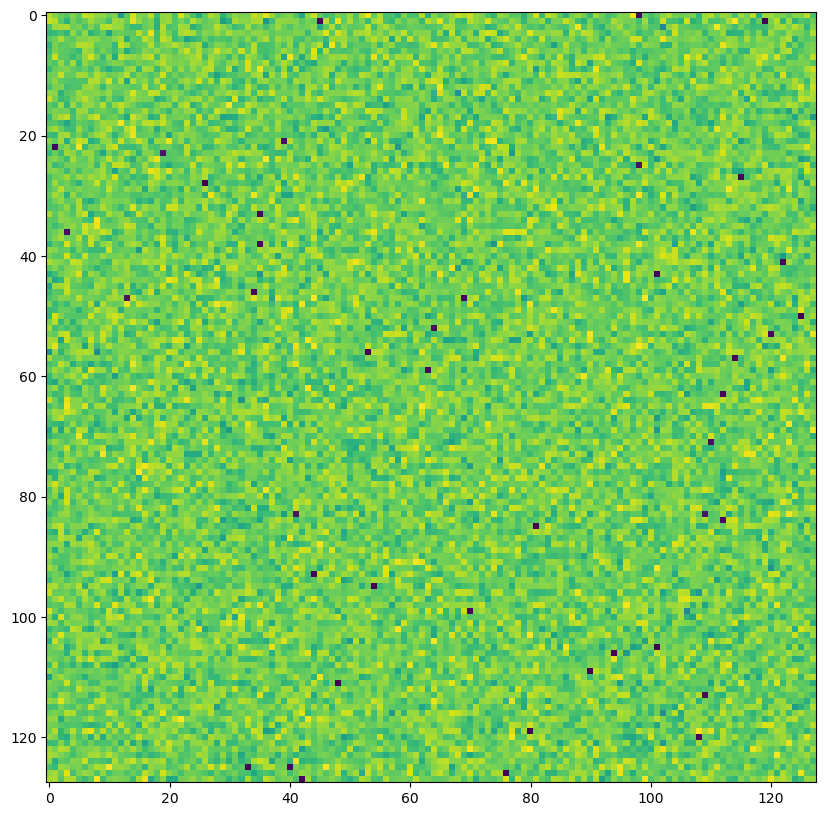

In [4]:
image, label = gen_random_binary_test_image(128, 128)
print('mean: {}'.format(np.mean(image)))
print('mask: {}'.format(np.max(label)))
plt.imshow(image.reshape((image.shape[0], image.shape[1])))

### Batch of data

Training is usually done using a batch of data. For semantic segmentation, that will be a batch of image (patches). We will also add the normalization of the data in this step. 

We will just scale the images in the range 0.0 to 1.0 from the full range of 0 to 255. Other possibilities are to scale the images individually according to their minimum and maximum values.


In [5]:
def gen_batch_binary(batch_size, height: int, width: int):
    image_list = []
    label_list = []
    for i in range(batch_size):
        img, label = gen_random_binary_test_image(height=height, width=width)
        image_list.append(img.astype(np.float32) / 255.0)
        label_list.append(label.astype(np.float32))

    image_batch = np.array(image_list, dtype=np.float32)
    label_batch = np.array(label_list, dtype=np.float32)

    # explicitely reshape labels
    label_batch = label_batch.reshape(batch_size, height, width, 1)

    return image_batch, label_batch

In [6]:
image_batch, label_batch = gen_batch_binary(100, 128, 128)
print(image_batch.shape)

(100, 128, 128, 1)


## Simple FCN

We will create a simple fully convolutional neural network for processing a batch of image patches

In [7]:
def fcn_simple_no_border(input_height:int, input_width:int) -> keras.Model:
    """
    Create a simple fcn model for semantic segmentation with 2 classes
    """
    model = keras.Sequential()
    
    # we use grayscale (1-channel input)
    
    # (used to define input shape on the first layers)
    model.add(keras.layers.Layer(input_shape=(input_height , input_width, 1)))
    
    # add 3 convolutional layers with 3x3 filters
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.Convolution2D(filters=8, kernel_size=3, padding='same', activation='relu'))
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, padding='same', activation='relu'))
    
    # go to logits which is the number of classes and add sigmoid layer for activation
    model.add(keras.layers.Convolution2D(filters=1, kernel_size=1, activation=None, 
                                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.001, seed=None)))
    model.add(keras.layers.Activation('sigmoid'))
    
    return model

In [8]:
model = fcn_simple_no_border(128, 128)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer (Layer)               (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 4)       40        
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 8)       296       
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 4)       292       
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 1)       5         
                                                                 
 activation (Activation)     (None, 128, 128, 1)       0         
                                                                 
Total params: 633
Trainable params: 633
Non-trainable pa

In [10]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Lets see if the model works....

In [11]:
history = model.fit(image_batch, label_batch, epochs=50, batch_size = 100, verbose=1)

Epoch 1/50
1/1 [==============================] - 1s 834ms/step - loss: 0.6931 - accuracy: 0.4403
Epoch 2/50
1/1 [==============================] - 0s 297ms/step - loss: 0.6930 - accuracy: 0.5200
Epoch 3/50
1/1 [==============================] - 0s 313ms/step - loss: 0.6928 - accuracy: 0.5200
Epoch 4/50
1/1 [==============================] - 0s 252ms/step - loss: 0.6926 - accuracy: 0.5200
Epoch 5/50
1/1 [==============================] - 0s 235ms/step - loss: 0.6924 - accuracy: 0.5200
Epoch 6/50
1/1 [==============================] - 0s 272ms/step - loss: 0.6921 - accuracy: 0.5200
Epoch 7/50
1/1 [==============================] - 0s 267ms/step - loss: 0.6919 - accuracy: 0.5200
Epoch 8/50
1/1 [==============================] - 0s 238ms/step - loss: 0.6915 - accuracy: 0.5200
Epoch 9/50
1/1 [==============================] - 0s 245ms/step - loss: 0.6911 - accuracy: 0.5200
Epoch 10/50
1/1 [==============================] - 0s 267ms/step - loss: 0.6907 - accuracy: 0.5200
Epoch 11/50
1/1 [==

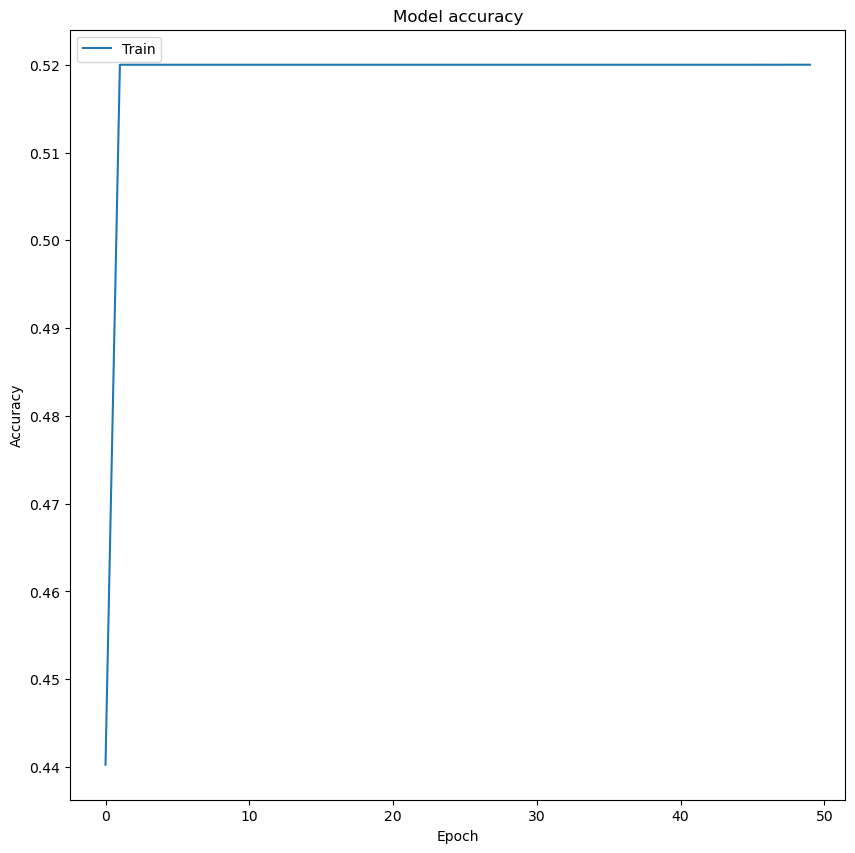

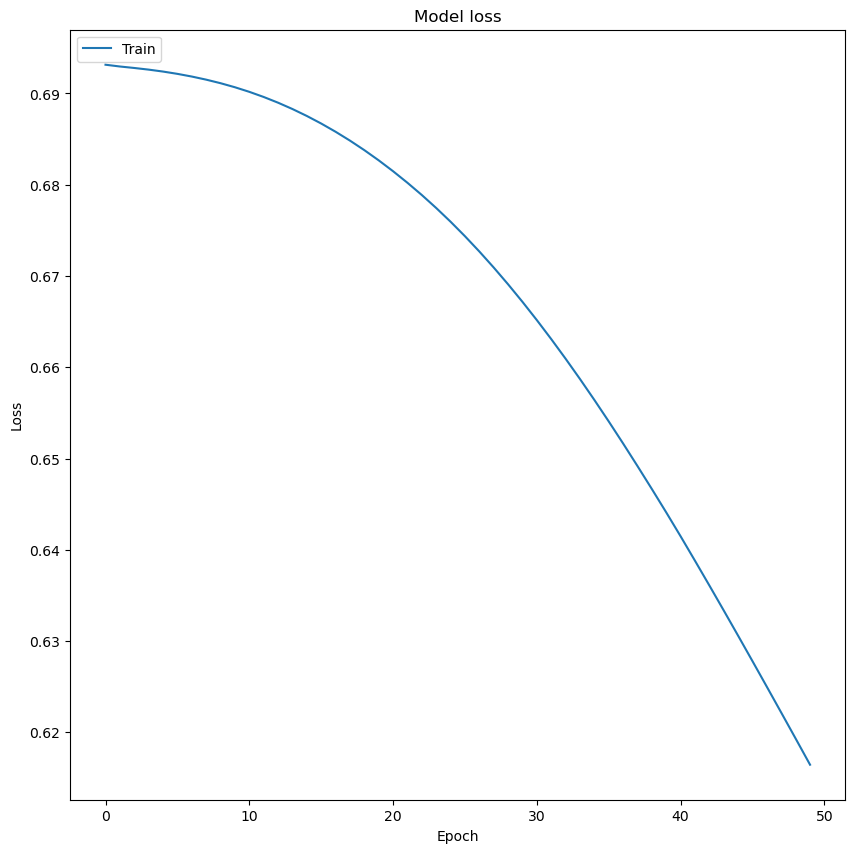

In [12]:
# Plot training accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [13]:
print('min, max, mean: {},{}, {}'.format(np.min(image_batch), np.max(image_batch), np.mean(image_batch)))

min, max, mean: 0.0,1.0, 0.592754602432251


## Training with generators

Reading the whole data set into memory is not always possible. There are different possibilities to that problem, one is to use the Dataset classes in the tensorflow backend. We will look at that a bit more in the next lecture. The other possibility is to use *generators* from python. A generator function to use for keras will generate a batch of data at the time. 

In [14]:
def batch_generator(batch_size, height: int, width: int):
    while True:
        image_batch, label_batch = gen_batch_binary(batch_size=batch_size, height=height, width=width)
        yield image_batch, label_batch

In order to use the generator, we can now use the standard ```model.fit``` function (in previous versions of keras we had to use the ```model.fit_generator``` function. 

In [15]:
PATCH_HEIGHT = 128
PATCH_WIDTH = 128
BATCH_SIZE = 100
EPOCHS = 10
STEPS_PER_EPOCHS = 100
model = fcn_simple_no_border(PATCH_HEIGHT, PATCH_WIDTH)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
        batch_generator(BATCH_SIZE, PATCH_HEIGHT, PATCH_WIDTH),
        epochs=EPOCHS,
        verbose=1,
        steps_per_epoch=STEPS_PER_EPOCHS,
        shuffle=False,
        callbacks=None)

Epoch 1/10
100/100 [==============================] - 39s 381ms/step - loss: 0.6410 - accuracy: 0.5053
Epoch 2/10
100/100 [==============================] - 40s 400ms/step - loss: 0.2492 - accuracy: 0.9666
Epoch 3/10
100/100 [==============================] - 40s 402ms/step - loss: 0.0143 - accuracy: 0.9999
Epoch 4/10
100/100 [==============================] - 41s 412ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 5/10
100/100 [==============================] - 41s 412ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 6/10
100/100 [==============================] - 48s 480ms/step - loss: 6.7210e-04 - accuracy: 1.0000
Epoch 7/10
100/100 [==============================] - 54s 544ms/step - loss: 4.5667e-04 - accuracy: 1.0000
Epoch 8/10
100/100 [==============================] - 39s 391ms/step - loss: 3.2773e-04 - accuracy: 1.0000
Epoch 9/10
100/100 [==============================] - 25s 250ms/step - loss: 2.4980e-04 - accuracy: 1.0000
Epoch 10/10
100/100 [==============================] - 26

## Exercise 1: Categorical data

In the example above we had only two classes, but in most applications we want to classify into more classes, as you have for example already done in the first homework, when classifying number.

Change the network and the generation of examples to use 5 classes.

## Exercise 2: Padding

Also in the example, we used padding for the convolutional filters by specifying ```padding='same'```. However this will not process the data at the edges correctly as the missing data will be filled with 0. For training it is preferable to use only the data that fits inside the convolutional filters. This can be specified using ```padding='valid'```. However then the labels will have to be resized accordingly.

Change the network to use *valid* padding.

## Exercise 3: Data preparation for homework 2

In the homework, you should train a network to recognise different categories from the cityscapes data base for autonomous driving. A link to the data set is available in moodle, it is a small copy of the data where the images have been divided into smaller patches for easier processing. 

More information about the data set can be found here: https://www.cityscapes-dataset.com/

First, let us look at the label distribution in the training data. Load the label images and calculate a histogram of the labels.

Also find the maximal id that occurs in the label images.

Display one of the image and the corresponding label image